In [46]:
# https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset/data for data set
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [47]:
current_dir = os.getcwd()
print(current_dir)

data = pd.read_csv('spam.csv', encoding='latin1')

c:\Users\yoson\OneDrive\Documents\git\ml_projects\sms_fraud


In [48]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [49]:
data = data[["v1", "v2"]] # data above is messed up, fix it
data.rename(columns = {"v1":"isFraud", "v2":"Text"}, inplace = True)
print(data.head())
print(data.info())

  isFraud                                               Text
0     ham  Go until jurong point, crazy.. Available only ...
1     ham                      Ok lar... Joking wif u oni...
2    spam  Free entry in 2 a wkly comp to win FA Cup fina...
3     ham  U dun say so early hor... U c already then say...
4     ham  Nah I don't think he goes to usf, he lives aro...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   isFraud  5572 non-null   object
 1   Text     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None


In [50]:
data.isnull().sum()

isFraud    0
Text       0
dtype: int64

In [51]:
data['isFraud'].value_counts() # ham > spam by a lot

isFraud
ham     4825
spam     747
Name: count, dtype: int64

In [52]:
data['isFraud'] = data['isFraud'].map({'ham': 0, 'spam': 1})
data.head()

,isFraud,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [53]:
# Features brainstorm: 
# num of words, sentences, characters
# ratio of alphabetical characters to special characters 
# occurance of words like [win, free, congratulations, click]

# For the case of this, we'll use the ideas above, and use NLP to determine most common words in spam and ham

In [58]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yoson\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yoson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yoson\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [55]:
def count_characters(text):
    alphabets = sum(c.isalpha() for c in text)
    specials = sum(not c.isalnum() and not c.isspace() for c in text)
    return alphabets, specials
data["Num_of_Characters"] = data["Text"].apply(len)
data["Num_of_Words"]=data.apply(lambda row: nltk.word_tokenize(row["Text"]), axis=1).apply(len)
data["Num_of_sentence"]=data.apply(lambda row: nltk.sent_tokenize(row["Text"]), axis=1).apply(len)
data[['Alphabets', 'Specials']] = data['Text'].apply(lambda x: pd.Series(count_characters(x)))
data['Ratio'] = data.apply(lambda row: row['Alphabets'] / row['Specials'] if row['Specials'] != 0 else 0, axis=1)

data.head()

,isFraud,Text,Num_of_Characters,Num_of_Words,Num_of_sentence,Alphabets,Specials,Ratio
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,83,9,9.222222
1,0,Ok lar... Joking wif u oni...,29,8,2,18,6,3.000000
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,97,6,16.166667
3,0,U dun say so early hor... U c already then say...,49,13,1,33,6,5.500000
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,47,2,23.500000


In [56]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
isFraud,5572.0,0.134063,0.340751,0.0,0.000000,0.0000,0.0,1.0
Num_of_Characters,5572.0,80.118808,59.690841,2.0,36.000000,61.0000,121.0,910.0
Num_of_Words,5572.0,18.699390,13.741932,1.0,9.000000,15.0000,27.0,220.0
Num_of_sentence,5572.0,1.996411,1.520159,1.0,1.000000,1.5000,2.0,38.0
Alphabets,5572.0,58.852477,43.485964,0.0,27.000000,46.0000,88.0,718.0
Specials,5572.0,4.287150,4.685449,0.0,2.000000,3.0000,6.0,133.0
Ratio,5572.0,16.903696,14.693420,0.0,7.589286,13.6125,22.5,126.0


<Figure size 1200x800 with 0 Axes>

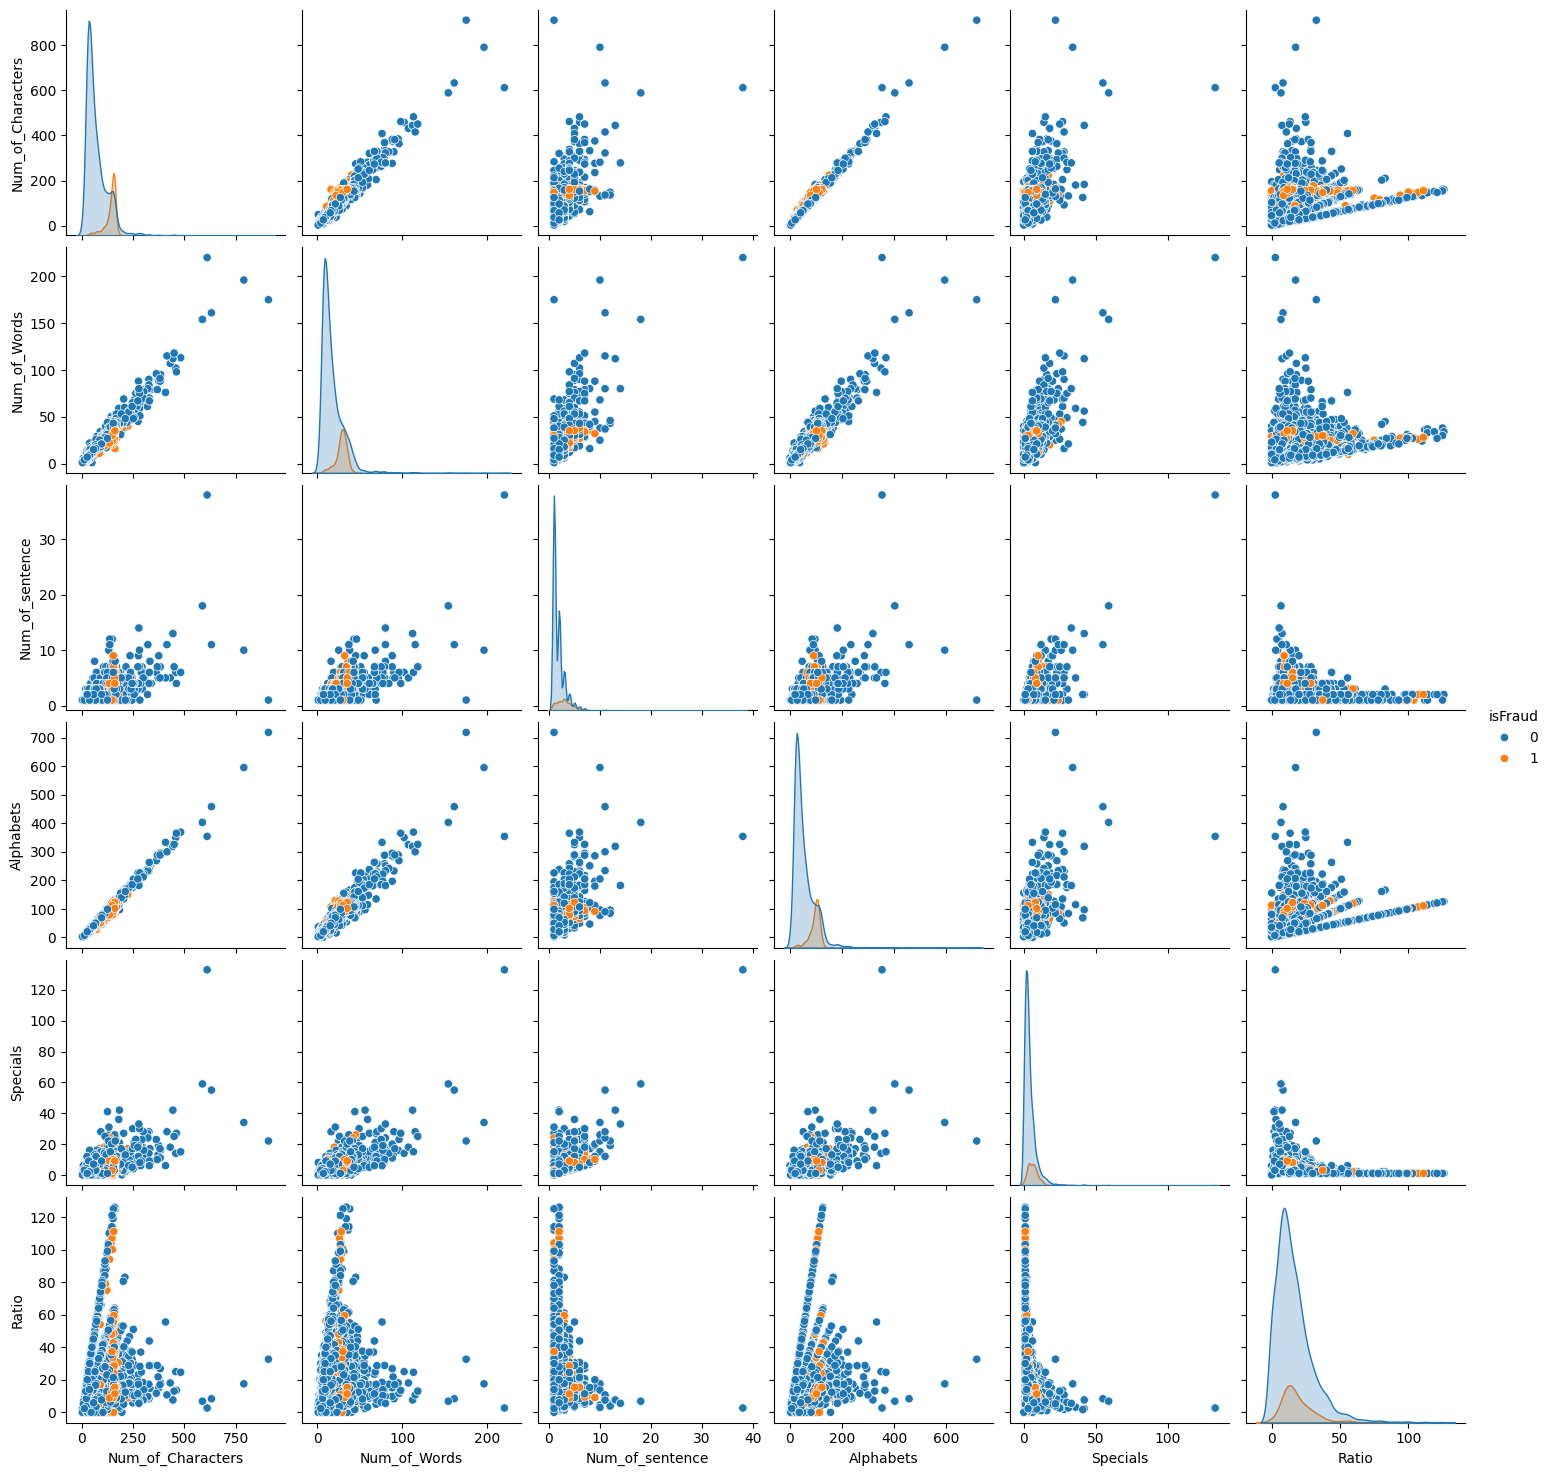

In [57]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="isFraud")
plt.show(fg)

In [ ]:
#### for nlp section

In [61]:
# cleaning: get rid of special characters and convert to one case, as the computer sees upper case and lower case differently
def Clean(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text)
    sms = sms.lower()
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

data["Clean_Text"] = data["Text"].apply(Clean)
data["Clean_Text"].head()

0    go until jurong point crazy available only in ...
1                              ok lar joking wif u oni
2    free entry in a wkly comp to win fa cup final ...
3          u dun say so early hor u c already then say
4    nah i don t think he goes to usf he lives arou...
Name: Clean_Text, dtype: object

In [63]:
# tokenization: break larger data into smaller tokens. in this case we'll break it down into list of words
data["Tokenize_Text"]=data.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)
data["Tokenize_Text"].head()

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, a, wkly, comp, to, win, fa, ...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, don, t, think, he, goes, to, usf, he,...
Name: Tokenize_Text, dtype: object

In [65]:
# remove stopwords: remove common sentence particles that don't contribute much to NLP
def remove_stopwords(text):
    stop_words = set(stopwords.words("english")) # list of stopwors from NLTK library
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

data["Nostopword_Text"] = data["Tokenize_Text"].apply(remove_stopwords)
data["Nostopword_Text"].head()

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, wkly, comp, win, fa, cup, final,...
3        [u, dun, say, early, hor, u, c, already, say]
4       [nah, think, goes, usf, lives, around, though]
Name: Nostopword_Text, dtype: object

In [67]:
# lemmanizing: changing words back to its root form (i.e. 'say' and 'said' would both be 'say').
# we do this because the words basically have the same meaning, just different conjugation

lemmatizer = WordNetLemmatizer()

def lemmatize_word(text):
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

data["Lemmatized_Text"] = data["Nostopword_Text"].apply(lemmatize_word)
data["Lemmatized_Text"].head()

0    [go, jurong, point, crazy, available, bugis, n...
1                         [ok, lar, joke, wif, u, oni]
2    [free, entry, wkly, comp, win, fa, cup, final,...
3        [u, dun, say, early, hor, u, c, already, say]
4          [nah, think, go, usf, live, around, though]
Name: Lemmatized_Text, dtype: object

In [76]:
#Creating a corpus of text feature to encode further into vectorized form
def corpus(lemma_list):
    msg = ' '.join([row for row in lemma_list])
    return msg
    
data["Corpus_Text"] = data["Lemmatized_Text"].apply(corpus)
data["Corpus_Text"].head()


0    go jurong point crazy available bugis n great ...
1                                ok lar joke wif u oni
2    free entry wkly comp win fa cup final tkts st ...
3                  u dun say early hor u c already say
4                  nah think go usf live around though
Name: Corpus_Text, dtype: object

In [81]:
from collections import Counter

words = data[data.isFraud==False]["Corpus_Text"].apply(lambda x: [word.lower() for word in x.split()])
ham_words = Counter()

for msg in words:
    ham_words.update(msg)
    
print('Most common ham words: ' + str(ham_words.most_common(20)))


words = data[data.isFraud==True]["Corpus_Text"].apply(lambda x: [word.lower() for word in x.split()])
spam_words = Counter()

for msg in words:
    spam_words.update(msg)
print('Most common spam words: ' + str(spam_words.most_common(20)))

Most common ham words: [('u', 1026), ('get', 616), ('go', 527), ('come', 323), ('gt', 318), ('lt', 316), ('call', 298), ('ok', 287), ('know', 261), ('like', 243), ('ur', 241), ('love', 235), ('time', 234), ('good', 233), ('say', 227), ('day', 216), ('want', 214), ('send', 201), ('think', 198), ('tell', 194)]
Most common spam words: [('call', 395), ('free', 228), ('u', 186), ('p', 180), ('txt', 170), ('ur', 144), ('mobile', 129), ('text', 126), ('stop', 126), ('claim', 115), ('reply', 113), ('www', 98), ('prize', 97), ('get', 97), ('tone', 90), ('send', 82), ('cash', 76), ('win', 74), ('uk', 74), ('service', 73)]


In [82]:
# instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(data['Corpus_Text']).toarray()
X.dtype

dtype('float64')

In [ ]:
# building & training model

In [85]:
#Setting values for labels and feature as y and X
y = data["isFraud"] 
# Splitting the testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [86]:
#Testing on the following classifiers
classifiers = [DecisionTreeClassifier(), 
               RandomForestClassifier(),
               KNeighborsClassifier()]

# as I've only learned about these classifiers from the textbook and the courses so far

for cls in classifiers:
    cls.fit(X_train, y_train)


In [87]:
pipe_dict = {0: "DecisionTree", 1: "RandomForest", 2: "KNeighbours"}

# cross validating this 
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train,y_train,scoring="accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

DecisionTree: 0.963703 
RandomForest: 0.978460 
KNeighbours: 0.915834 


In [88]:
precision =[]
recall =[]
f1_score = []
trainset_accuracy = []
testset_accuracy = []

for i in classifiers:
    pred_train = i.predict(X_train)
    pred_test = i.predict(X_test)
    prec = metrics.precision_score(y_test, pred_test)
    recal = metrics.recall_score(y_test, pred_test)
    f1_s = metrics.f1_score(y_test, pred_test)
    train_accuracy = model.score(X_train,y_train)
    test_accuracy = model.score(X_test,y_test)
  
    #Appending scores
    precision.append(prec)
    recall.append(recal)
    f1_score.append(f1_s)
    trainset_accuracy.append(train_accuracy)
    testset_accuracy.append(test_accuracy)

In [89]:
# create table for precision/recall, harmonic mean (F1score), accuracy 
data = {'Precision':precision,
'Recall':recall,
'F1score':f1_score,
'Accuracy on Testset':testset_accuracy,
'Accuracy on Trainset':trainset_accuracy}
Results = pd.DataFrame(data, index =["DecisionTree", "RandomForest", "KNeighbours"])

In [90]:
#visualize table 
cmap2 = ListedColormap(["#E2CCFF","#E598D8"])
Results.style.background_gradient(cmap=cmap2)

,Precision,Recall,F1score,Accuracy on Testset,Accuracy on Trainset
DecisionTree,0.923077,0.895522,0.909091,0.939068,0.927204
RandomForest,1.000000,0.880597,0.936508,0.939068,0.927204
KNeighbours,1.000000,0.492537,0.660000,0.939068,0.927204


In [ ]:
# From this we can tell from the precision/recall/F1-score that RandomForest Classifier seems to work the best.